In [ ]:
# Data Manipulation
import pandas as pd
import numpy as np
import requests
from io import StringIO

# Visualization (Static)
import matplotlib.pyplot as plt
import seaborn as sns

# Visualization (Interactive)
import plotly.express as px

# Machine Learning & Clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Import Data 

In [240]:
# 1) All variables and countries from the master data
final_df_long= pd.read_csv("https://raw.githubusercontent.com/AyaanTigdikar/Capstone/refs/heads/main/workingdata/master_data_long.csv")
final_df_long = final_df_long.drop(columns=['Unnamed: 0'], errors='ignore')

# 2) Clusters list from Leo
clusters_list = pd.read_csv('https://raw.githubusercontent.com/AyaanTigdikar/Capstone/refs/heads/main/workingdata/clusters_list.csv')

# Cluster variations across time 

### Pre-processing 

In [241]:
# I will take 5-year averages (from 1991 to 1995, and 2020 to 2024)
# Only use years from 2015 to 2021
final_df_long['Year'] = final_df_long['Year'].astype(int)
df_start_end = final_df_long[final_df_long['Year'].isin([1991, 1992, 1993, 1994, 1995, 2015, 2016, 2017, 2018, 2019])].copy()

# Pivot the data to wide format
data_pivot_var = df_start_end.pivot_table(
    index=['Country Code', 'Variable'], 
    columns='Year', 
    values='Value'
)

# Take 5-year averages
years_91_95 = [1991, 1992, 1993, 1994, 1995]
years_20_24 = [2015, 2016, 2017, 2018, 2019]

data_pivot_var['avg_1991_1995'] = data_pivot_var[years_91_95].mean(axis=1)
data_pivot_var['avg_2020_2024'] = data_pivot_var[years_20_24].mean(axis=1)

# Calculate absolute change between 5-year averages
df_change = (data_pivot_var['avg_2020_2024'] - data_pivot_var['avg_1991_1995']).reset_index()
df_change.columns = ['Country Code', 'Variable', 'Net_Change'] 

# To wide format
df_change_wide = df_change.pivot(
    index='Country Code', 
    columns='Variable', 
    values='Net_Change'
)

# Merge with clusters_list from first cluster 
df_change_clusters = df_change_wide.merge(
    clusters_list,
    how='right',
    on='Country Code'
)

# Keep only clusters 1, 2 and 4
#df_change_clusters = df_change_clusters[df_change_clusters['cluster_6'].isin([1, 2, 4])]


#### NA check

In [242]:
df_change_clusters.shape # 136 countries

(136, 22)

In [243]:
df_change_clusters.isna().sum() # Really bad. ECI is the best.

Country Code                                                  0
Adjusted savings: natural resources depletion (% of GNI)     16
Adjusted savings: total (current US$)                        40
Agriculture                                                  11
Economic Complexity Index                                     4
GDP per capita (constant prices, PPP)                         5
Government revenue                                           35
High-tech exports                                           136
Industry                                                     13
Manufacturing                                                25
Mineral rents (% of GDP)                                      2
Natural gas rents (% of GDP)                                  2
Oil rents (% of GDP)                                          2
Services                                                     15
Total natural resources rents (% of GDP)                      2
deliberative_dem                        

### ECI list (continuous labels)

In [256]:
# Create a categorical variable with 3 equally sized groups
df_change_clusters['label'] = pd.qcut(
    df_change_clusters['Economic Complexity Index'], 
    q=3,  # split into 3 quantiles
    labels=['Not Successful', 'Mid Successful', 'Successful']
)

# Create a categorical variable with 3 equally sized groups
df_change_clusters['label_services'] = pd.qcut(
    df_change_clusters['Services'], 
    q=3,  # split into 3 quantiles
    labels=['Not Successful', 'Mid Successful', 'Successful']
)

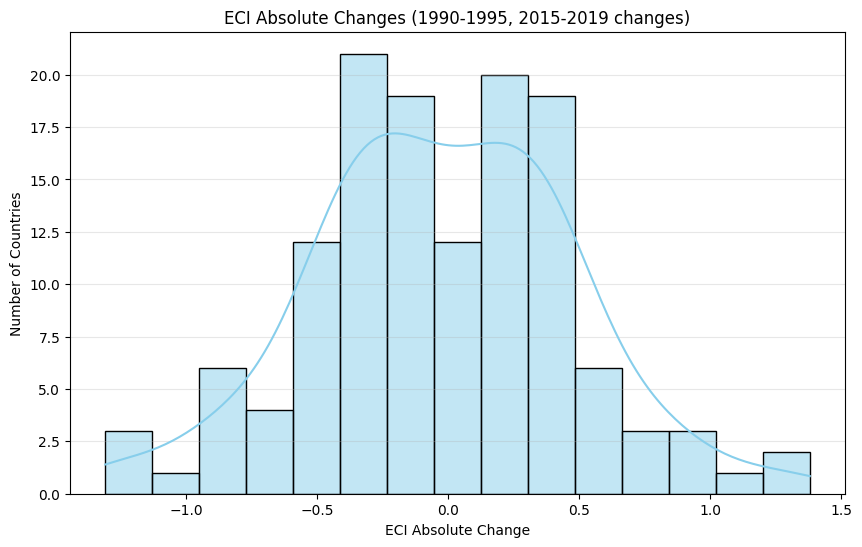

In [245]:
# --- 1. Histogram of ECI changes ---
plt.figure(figsize=(10,6))
sns.histplot(df_change_clusters['Economic Complexity Index'], bins=15, kde=True, color='skyblue')
plt.title('ECI Absolute Changes (1990-1995, 2015-2019 changes)')
plt.xlabel('ECI Absolute Change')
plt.ylabel('Number of Countries')
plt.grid(axis='y', alpha=0.3)
plt.show()

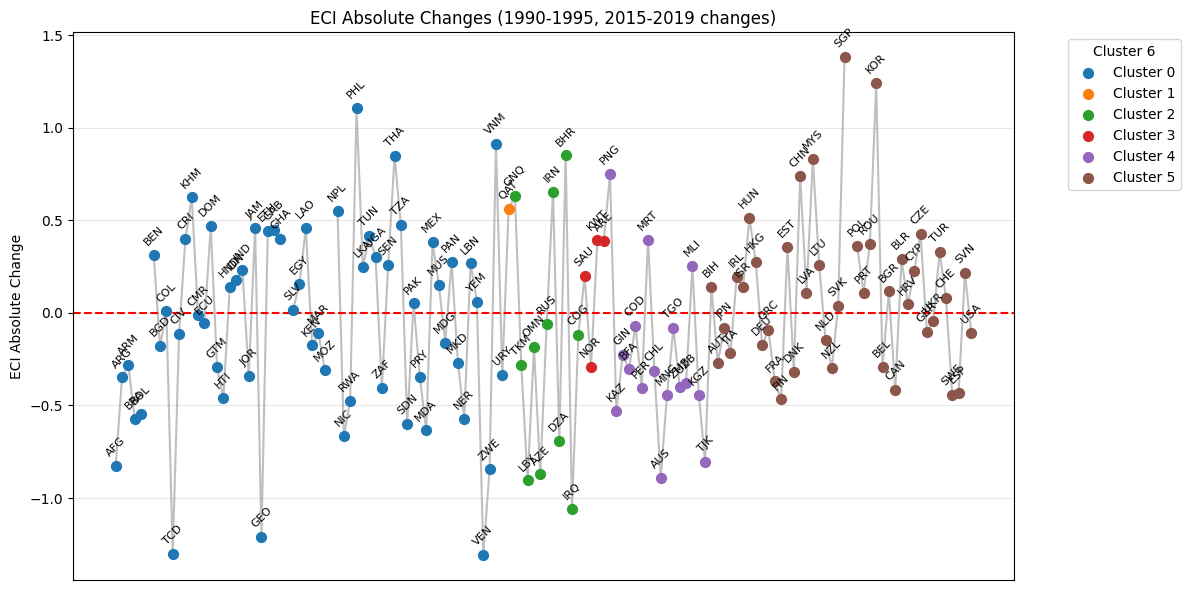

In [249]:
# Sort by cluster_6
df_sorted = df_change_clusters.sort_values('cluster_6').reset_index(drop=True)

plt.figure(figsize=(12,6))

# Generate a color palette based on unique clusters
unique_clusters = df_sorted['cluster_6'].unique()
palette = sns.color_palette("tab10", n_colors=len(unique_clusters))
cluster_colors = {cluster: color for cluster, color in zip(unique_clusters, palette)}

# Plot line connecting points (gray)
plt.plot(df_sorted.index, df_sorted['Economic Complexity Index'], linestyle='-', color='gray', alpha=0.5)

# Plot points colored by cluster and annotate
for cluster in unique_clusters:
    cluster_data = df_sorted[df_sorted['cluster_6'] == cluster]
    sc = plt.scatter(cluster_data.index, cluster_data['Economic Complexity Index'],
                     color=cluster_colors[cluster], s=50, label=f'Cluster {cluster}', zorder=3)
    # Annotate each point with country code
    for i, row in cluster_data.iterrows():
        plt.text(i, row['Economic Complexity Index'] + 0.04, row['Country Code'], 
                 ha='center', va='bottom', fontsize=8, rotation=45)

# Add red dashed horizontal line at 0
plt.axhline(y=0.0, color='red', linestyle='--', linewidth=1.5)

# Remove x-axis labels
plt.xticks([])

plt.title('ECI Absolute Changes (1990-1995, 2015-2019 changes)')
plt.xlabel('')
plt.ylabel('ECI Absolute Change')
plt.grid(alpha=0.3)
plt.legend(title='Cluster 6', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

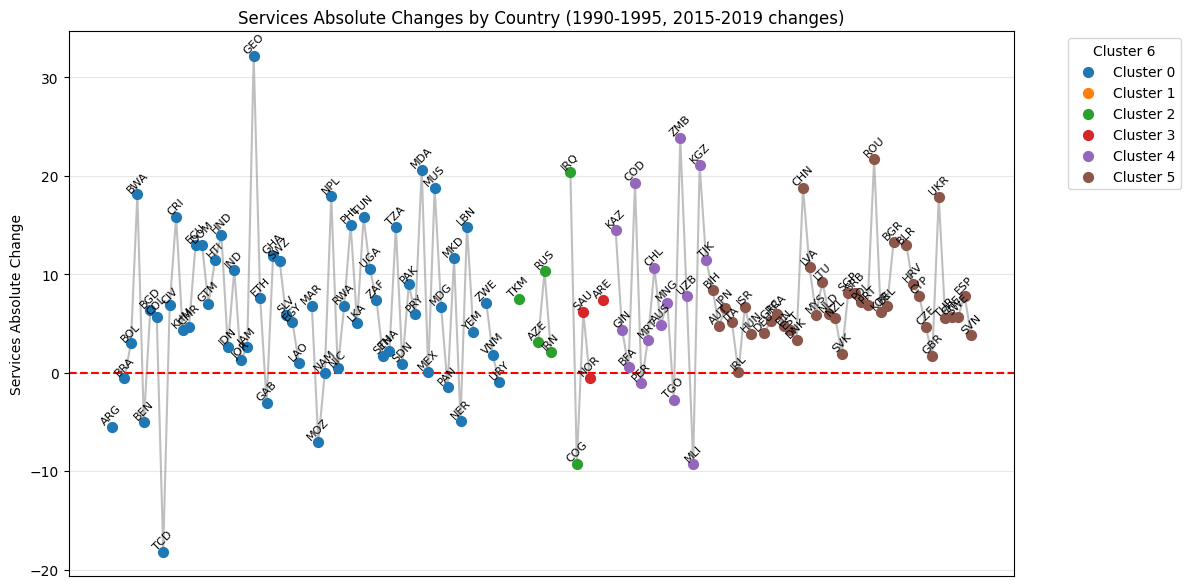

In [ ]:
# Sort by cluster_6
df_sorted = df_change_clusters.sort_values('cluster_6').reset_index(drop=True)

plt.figure(figsize=(12,6))

# Generate a color palette based on unique clusters
unique_clusters = df_sorted['cluster_6'].unique()
palette = sns.color_palette("tab10", n_colors=len(unique_clusters))
cluster_colors = {cluster: color for cluster, color in zip(unique_clusters, palette)}

# Plot line connecting points (gray)
plt.plot(df_sorted.index, df_sorted['Services'], linestyle='-', color='gray', alpha=0.5)

# Plot points colored by cluster and annotate
for cluster in unique_clusters:
    cluster_data = df_sorted[df_sorted['cluster_6'] == cluster]
    sc = plt.scatter(cluster_data.index, cluster_data['Services'],
                     color=cluster_colors[cluster], s=50, label=f'Cluster {cluster}', zorder=3)
    # Annotate each point with country code
    for i, row in cluster_data.iterrows():
        plt.text(i, row['Services'] + 0.04, row['Country Code'], 
                 ha='center', va='bottom', fontsize=8, rotation=45)

# Add red dashed horizontal line at 0
plt.axhline(y=0.0, color='red', linestyle='--', linewidth=1.5)

# Remove x-axis labels
plt.xticks([])

plt.title('Services Absolute Changes (1990-1995, 2015-2019 changes)')
plt.xlabel('')
plt.ylabel('Services Absolute Change')
plt.grid(alpha=0.3)
plt.legend(title='Cluster 6', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

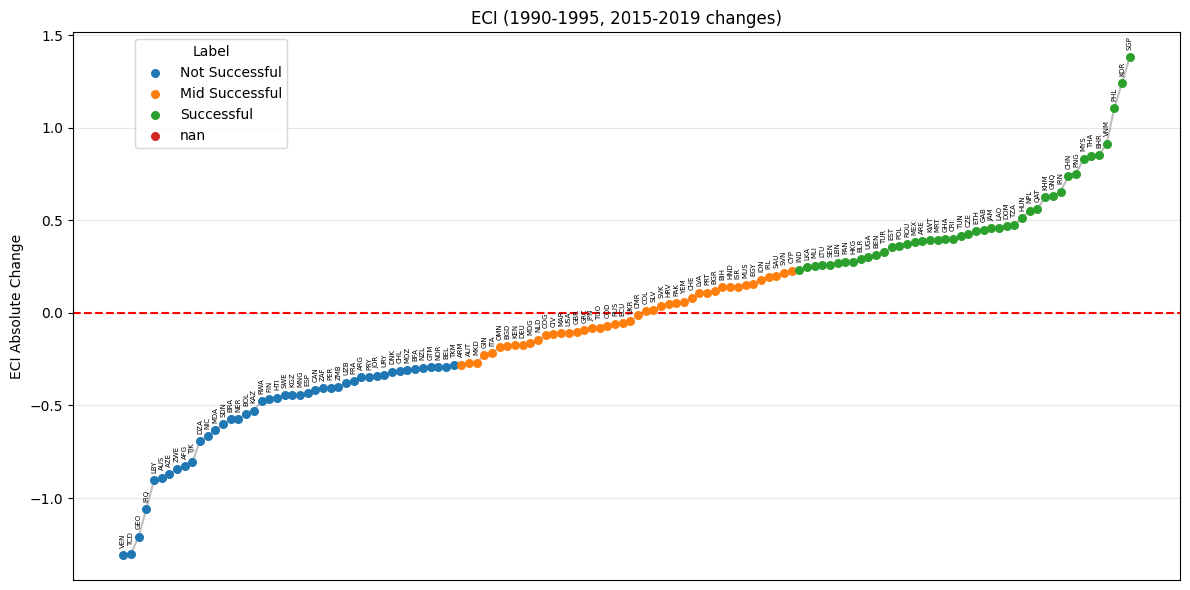

In [ ]:
# Sort by ECI change
df_sorted = df_change_clusters.sort_values('Economic Complexity Index').reset_index(drop=True)

plt.figure(figsize=(12,6))

# Generate a color palette based on unique clusters
unique_clusters = df_sorted['label'].unique()
palette = sns.color_palette("tab10", n_colors=len(unique_clusters))
cluster_colors = {cluster: color for cluster, color in zip(unique_clusters, palette)}

# Plot line connecting points (gray)
plt.plot(df_sorted.index, df_sorted['Economic Complexity Index'], linestyle='-', color='gray', alpha=0.5)

# Plot points colored by cluster and keep references for legend
scatter_handles = []
for cluster in unique_clusters:
    cluster_data = df_sorted[df_sorted['label'] == cluster]
    sc = plt.scatter(cluster_data.index, cluster_data['Economic Complexity Index'],
                     color=cluster_colors[cluster], s=30, label=f'{cluster}', zorder=3)
    scatter_handles.append(sc)
    # Annotate each point with country code
    for i, row in cluster_data.iterrows():
        plt.text(i, row['Economic Complexity Index'] + 0.04, row['Country Code'], 
                 ha='center', va='bottom', fontsize=5, rotation=90)


# Remove x-axis labels
plt.xticks([])
# Add red dashed horizontal line at 0
plt.axhline(y=0.0, color='red', linestyle='--', linewidth=1.5)
plt.title('ECI Absolute Change (1990-1995, 2015-2019 changes)')
plt.xlabel('')
plt.ylabel('ECI Absolute Change')
plt.grid(alpha=0.3)
plt.legend(title='Label', bbox_to_anchor=(.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

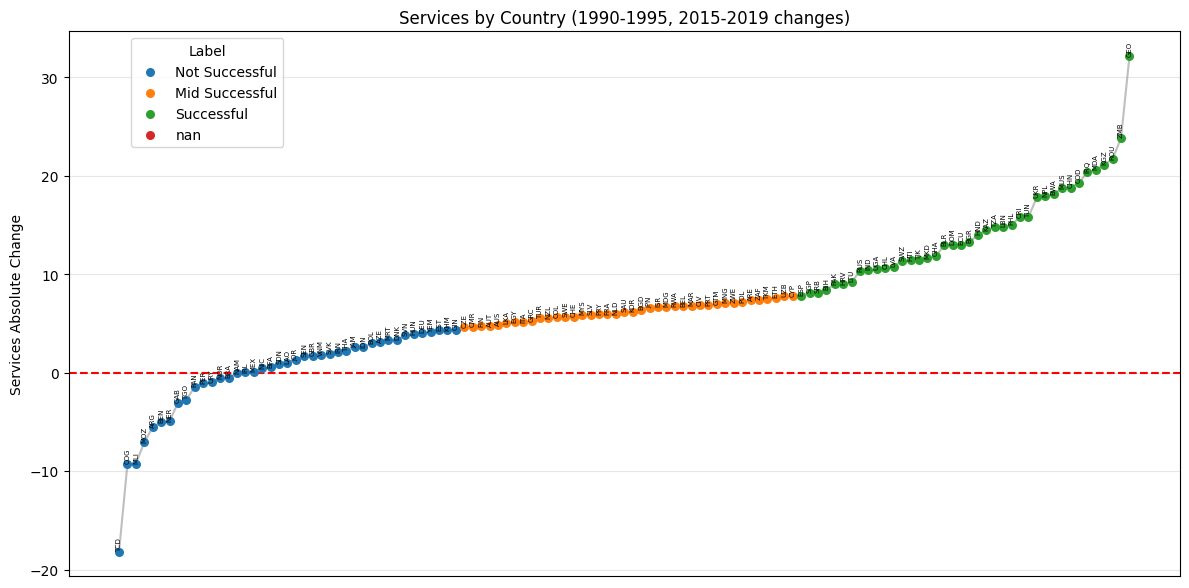

In [ ]:
# Sort by ECI change
df_sorted = df_change_clusters.sort_values('Services').reset_index(drop=True)

plt.figure(figsize=(12,6))

# Generate a color palette based on unique clusters
unique_clusters = df_sorted['label_services'].unique()
palette = sns.color_palette("tab10", n_colors=len(unique_clusters))
cluster_colors = {cluster: color for cluster, color in zip(unique_clusters, palette)}

# Plot line connecting points (gray)
plt.plot(df_sorted.index, df_sorted['Services'], linestyle='-', color='gray', alpha=0.5)

# Plot points colored by cluster and keep references for legend
scatter_handles = []
for cluster in unique_clusters:
    cluster_data = df_sorted[df_sorted['label_services'] == cluster]
    sc = plt.scatter(cluster_data.index, cluster_data['Services'],
                     color=cluster_colors[cluster], s=30, label=f'{cluster}', zorder=3)
    scatter_handles.append(sc)
    # Annotate each point with country code
    for i, row in cluster_data.iterrows():
        plt.text(i, row['Services'] + 0.04, row['Country Code'], 
                 ha='center', va='bottom', fontsize=5, rotation=90)


# Remove x-axis labels
plt.xticks([])
# Add red dashed horizontal line at 0
plt.axhline(y=0.0, color='red', linestyle='--', linewidth=1.5)
plt.title('Services Absolute Change (1990-1995, 2015-2019 changes)')
plt.xlabel('')
plt.ylabel('Services Absolute Change')
plt.grid(alpha=0.3)
plt.legend(title='Label', bbox_to_anchor=(.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## LASSO

## Random Forest

## Export matrix sophistication

In [184]:
products = pd.read_csv(r"C:\Users\iorueta\PC IGNACIO\0.LSE\MPA DSPP\3. Autumm Term 2025\Capstone Moody's\Capstone\rawdata\hs92_country_product_year_2.csv")

# Inspect
products.head()

,country_id,country_iso3_code,product_id,product_hs92_code,year,export_value,import_value,global_market_share,distance,cog,pci
0,4,AFG,100,1,1995,14517,0,0.000001,0.943,0.001,-0.565
1,4,AFG,100,1,1996,17207,0,0.000002,0.951,0.001,-0.631
2,4,AFG,100,1,1997,22781,0,0.000003,0.938,0.001,-0.519
3,4,AFG,100,1,2000,0,7786,0.000000,0.931,0.001,-0.605
4,4,AFG,100,1,2001,0,15592,0.000000,0.930,0.001,-0.825


In [186]:
YEAR = 2015   # choose a year
products_2015 = products[products['year'] == YEAR].copy()

In [189]:
# Total exports by country
country_totals = products_2015.groupby('country_iso3_code')['export_value'].sum()

# Total exports by product
product_totals = products_2015.groupby('product_id')['export_value'].sum()

# World total exports
world_total = products_2015['export_value'].sum()

# Merge totals
products_2015 = products_2015.merge(country_totals, on='country_iso3_code', suffixes=('', '_country'))
products_2015 = products_2015.merge(product_totals, on='product_id', suffixes=('', '_product'))

# RCA
products_2015['RCA'] = (
    (products_2015['export_value'] / products_2015['export_value_country']) /
    (products_2015['export_value_product'] / world_total)
)


products_2015['M'] = (products_2015['RCA'] >= 1).astype(int)

M = products_2015.pivot_table(
    index='country_iso3_code',
    columns='product_id',
    values='M',
    fill_value=0
)

In [190]:
M

product_id,100,101,102,103,104,105,106,107,108,109,...,187,188,189,190,191,192,193,194,195,196
country_iso3_code,,,,,,,,,,,,,,,,,,,,,
ABW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AFG,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
AGO,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AIA,0.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0
ALB,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
WSM,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
YEM,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ZAF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
